# Corpus shift KL minimisation


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cvxpy as cp
import seaborn as sns
import emm

# Generate example data
m = 10000
# Target distribution
mu0 = np.array([100]); sig0 = np.array([10])
mu1 = np.array([150]); sig1 = np.array([15])
X0 = np.random.normal(loc=mu0, scale=sig0, size=m // 2)
X1 = np.random.normal(loc=mu1, scale=sig1, size=m // 2)
y0 = np.zeros(m // 2)
y1 = np.ones(m // 2)
X = np.concatenate([X0,X1])
y = np.concatenate([y0,y1])

target = pd.DataFrame({'feature' : X})
target['Outcome'] = y

# Corpus distribution
mu = np.array([125]); sig = np.array([15])
corpus = np.random.normal(loc=mu, scale=sig, size=m)
corpus = pd.DataFrame({'feature': corpus})

Plot histograms for corpus and target distribution

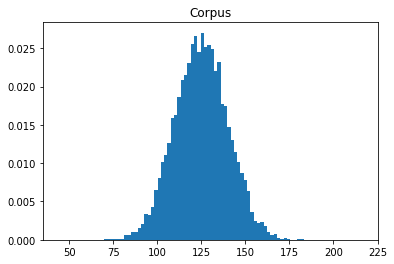

In [2]:
bins = np.histogram_bin_edges(corpus['feature'],bins='auto')
plt.hist(corpus['feature'],bins=bins, density=True)
plt.xlim([35,225])
plt.title("Corpus")
plt.show()

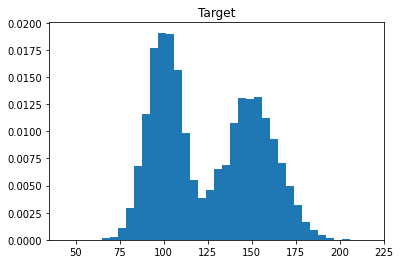

In [3]:
bins_target = np.histogram_bin_edges(target['feature'],bins='auto')
plt.hist(target['feature'],bins=bins_target, density=True)
plt.xlim([35,225])
plt.title("Target")
plt.show()

In [153]:
# Onehot encode histogram such that f @ w give histogram bar hieghts
from emm.common import onehot_hist
F,_ = onehot_hist(corpus['feature'],bins=bins)
F

,"(70.041, 71.924]","(71.924, 73.807]","(73.807, 75.69]","(75.69, 77.573]","(77.573, 79.456]","(79.456, 81.339]","(81.339, 83.222]","(83.222, 85.105]","(85.105, 86.988]","(86.988, 88.871]",...,"(164.192, 166.075]","(166.075, 167.958]","(167.958, 169.841]","(169.841, 171.724]","(171.724, 173.607]","(173.607, 175.49]","(175.49, 177.373]","(177.373, 179.256]","(179.256, 181.139]","(181.139, 183.022]"
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


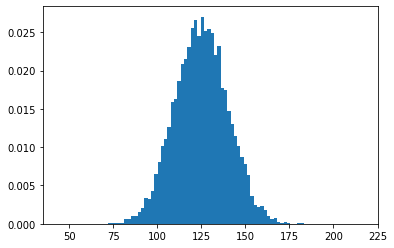

In [5]:
# Shows that f @ w give the probability of discrete proability distribution
p = F @ (np.ones(m) / m)
width=bins[1]-bins[0]
plt.bar(x=bins[:-1], height=p / width, width=width, align='edge')
plt.xlim([35,225])
plt.show()

In [6]:
# Shift and scale corpus according to desired marginals
target_0 = (corpus['feature']  - mu) * (sig0 / sig) + mu0
target_1 = (corpus['feature']  - mu) * (sig1 / sig) + mu1
# Create onehot histograms for desired marginals
fdes_0, _ = onehot_hist(target_0, bins=bins)
fdes_1, _ = onehot_hist(target_1, bins=bins)

# Desired marginals become histogram densities
fdes_0 = np.array(fdes_0).T @ np.ones(m) / m
fdes_1 = np.array(fdes_1).T @ np.ones(m) / m

$$\begin{align}
&\min \; D_{KL}(\mathbf f \| \mathbf f^\text{des}) + \lambda \sum_i w_i \log w_i \\
&\;\text{s.t} \quad \sum_i w_i = 1, \quad w_i \geq 0, \quad \mathbf f = \mathbf F \, \mathbf w
\end{align}$$ 

In [7]:
# Solve optimisation problem for first outcome
lam = 0.08
w = cp.Variable(m)
obj = cp.sum(cp.kl_div(F @ w, fdes_0)) - lam * cp.sum(cp.entr(w))
constrs = [cp.sum(w) == 1, w >= 0]
cp.Problem(cp.Minimize(obj), constrs).solve()
w_out_0 = w.value

c:\users\branko\documents\git projects\emm\env\lib\site-packages\cvxpy-1.1.13-py3.9-win-amd64.egg\cvxpy\atoms\elementwise\kl_div.py:37: RuntimeWarning: divide by zero encountered in true_divide
  return xlogy(x, x/y) - x + y
c:\users\branko\documents\git projects\emm\env\lib\site-packages\cvxpy-1.1.13-py3.9-win-amd64.egg\cvxpy\atoms\elementwise\kl_div.py:37: RuntimeWarning: invalid value encountered in true_divide
  return xlogy(x, x/y) - x + y


In [8]:
# Solve optimisation problem for second outcome
w = cp.Variable(m)
obj = cp.sum(cp.kl_div(F @ w, fdes_1)) - lam * cp.sum(cp.entr(w))
constrs = [cp.sum(w) == 1, w >= 0]
cp.Problem(cp.Minimize(obj), constrs).solve()
w_out_1 = w.value

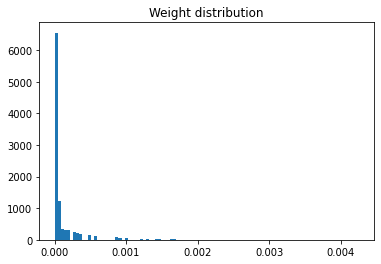

In [9]:
# Plot distribution of weights
bin_w = np.histogram_bin_edges(w_out_0, bins='sqrt')
plt.hist(w_out_0, bins=bin_w)
plt.title("Weight distribution")
plt.show()

Plot of the reweighted corpus for each outcome

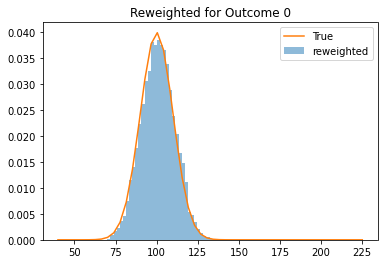

Mean = 100.9718740919746
Std = 10.133472128963728


In [10]:
from scipy.stats import norm
plt.hist(corpus['feature'], bins=bins, weights=w_out_0, alpha=0.5, density=True, label='reweighted')
x = np.linspace(40,225)
plt.plot(x, norm(loc = mu0, scale = sig0).pdf(x), label=True)
plt.legend()
plt.title("Reweighted for Outcome 0")
plt.show()
print("Mean = " + str(corpus['feature'] @ w_out_0))
print("Std = " + str(((corpus['feature'] - corpus['feature'] @ w_out_0)**2 @ w_out_0)**(1/2)))

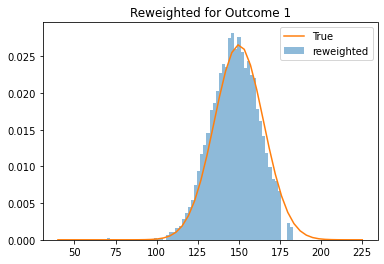

Mean = 147.14223057246022
Std = 14.246194782303947


In [11]:
from scipy.stats import norm
plt.hist(corpus['feature'], bins=bins, weights=w_out_1, alpha=0.5, density=True, label='reweighted')
x = np.linspace(40,225)
plt.plot(x, norm(loc = mu1, scale = sig1).pdf(x), label=True)
plt.legend()
plt.title("Reweighted for Outcome 1")
plt.show()
print("Mean = " + str(corpus['feature'] @ w_out_1))
print("Std = " + str(((corpus['feature'] - corpus['feature'] @ w_out_1)**2 @ w_out_1)**(1/2)))

In [12]:
rw_corp = pd.concat([corpus,corpus], axis=0, ignore_index=True)
weights = np.concatenate([w_out_0 / 2, w_out_1 / 2])
label = np.concatenate([np.zeros(m), np.ones(m)])
rw_corp['weights'] = weights
rw_corp['Outcome'] = label

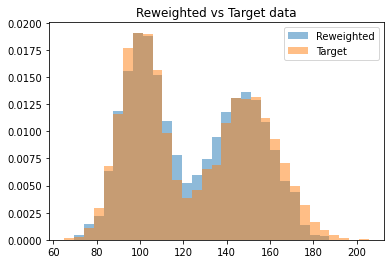

In [13]:
width = bins_target[1] - bins_target[0]
plt.hist(rw_corp['feature'], bins=bins_target, weights=weights/width, alpha=0.5, label="Reweighted")
plt.hist(target['feature'], bins=bins_target, alpha=0.5, density=True, label="Target")
plt.title("Reweighted vs Target data")
plt.legend()
plt.show()

c:\users\branko\documents\git projects\emm\env\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\branko\documents\git projects\emm\env\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


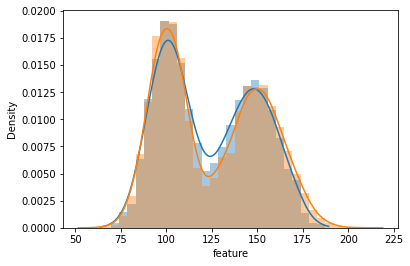

In [14]:
sns.distplot(rw_corp['feature'],bins=bins_target, hist_kws={'weights': weights/width}, kde_kws={'weights': weights/width})
sns.distplot(target['feature'], bins=bins_target)
plt.show()

In [15]:
emm.metrics.kl_divergence(np.histogram(rw_corp['feature'], bins=bins_target, weights= weights/width)[0],
                         np.histogram(target['feature'], bins=bins_target, normed=True)[0])

<ipython-input-15-cc34b729b38e>:2: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  np.histogram(target['feature'], bins=bins_target, normed=True)[0])


0.0043084726988227955

In [20]:
from sklearn.tree import DecisionTreeClassifier
param_grid =  {'classifier' : [DecisionTreeClassifier()],
     'classifier__max_depth' : [2,4,6,7,9]}

In [21]:

emm.metrics.classifier_metric(target, rw_corp, param_grid, verbose=True)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Target data: the best parameters are given by 
 DecisionTreeClassifier(max_depth=2)
 the best mean cross-validation accuracy 97.7625 +/- 0.20691% on training dataset 



{'accuracy_score': {'RR': 0.9755,
  'RS': 0.9717099230466647,
  'SS': 0.9718069126650208,
  'SR': 0.976}}

In [151]:
import copy
bins = onehot_hist(corpus['feature'])[1]
ivs = pd.IntervalIndex.from_arrays(bins[:-1], bins[1:])
funs = []
i=0


for iv in ivs:
    print(iv)
    funs.append(lambda x : (1 if x in copy.deepcopy(iv) else 0))
    

(70.04078694720951, 71.9238036218245]
(71.9238036218245, 73.8068202964395]
(73.8068202964395, 75.6898369710545]
(75.6898369710545, 77.5728536456695]
(77.5728536456695, 79.45587032028449]
(79.45587032028449, 81.33888699489948]
(81.33888699489948, 83.22190366951449]
(83.22190366951449, 85.10492034412948]
(85.10492034412948, 86.98793701874447]
(86.98793701874447, 88.87095369335947]
(88.87095369335947, 90.75397036797446]
(90.75397036797446, 92.63698704258947]
(92.63698704258947, 94.52000371720446]
(94.52000371720446, 96.40302039181945]
(96.40302039181945, 98.28603706643446]
(98.28603706643446, 100.16905374104945]
(100.16905374104945, 102.05207041566445]
(102.05207041566445, 103.93508709027944]
(103.93508709027944, 105.81810376489443]
(105.81810376489443, 107.70112043950942]
(107.70112043950942, 109.58413711412443]
(109.58413711412443, 111.46715378873942]
(111.46715378873942, 113.35017046335443]
(113.35017046335443, 115.23318713796942]
(115.23318713796942, 117.11620381258442]
(117.116203812

1

In [150]:
type(ivs[0])

pandas._libs.interval.Interval

In [152]:
bins

array([ 70.04078695,  71.92380362,  73.8068203 ,  75.68983697,
        77.57285365,  79.45587032,  81.33888699,  83.22190367,
        85.10492034,  86.98793702,  88.87095369,  90.75397037,
        92.63698704,  94.52000372,  96.40302039,  98.28603707,
       100.16905374, 102.05207042, 103.93508709, 105.81810376,
       107.70112044, 109.58413711, 111.46715379, 113.35017046,
       115.23318714, 117.11620381, 118.99922049, 120.88223716,
       122.76525384, 124.64827051, 126.53128719, 128.41430386,
       130.29732053, 132.18033721, 134.06335388, 135.94637056,
       137.82938723, 139.71240391, 141.59542058, 143.47843726,
       145.36145393, 147.24447061, 149.12748728, 151.01050396,
       152.89352063, 154.7765373 , 156.65955398, 158.54257065,
       160.42558733, 162.308604  , 164.19162068, 166.07463735,
       167.95765403, 169.8406707 , 171.72368738, 173.60670405,
       175.48972073, 177.3727374 , 179.25575407, 181.13877075,
       183.02178742])

In [158]:
{'feature' : {'feature 1', 'fun' : 'mean', 'target': 25 , 'loss'}


125.00701402438322

In [159]:
corpus['feature'].head()

0    131.463513
1    121.854715
2    135.369451
3    119.684462
4    125.919879
Name: feature, dtype: float64